# Flight Delay Prediction - Data Preparation & Feature Store

## Overview
This notebook demonstrates:
1. Data acquisition from Kaggle Flight Delay dataset (2019-2023)
2. Data preprocessing and feature engineering
3. Creating SageMaker Feature Groups
4. Ingesting data into Feature Store

**Business Goal:** Predict flight delays to help airlines optimize operations and improve passenger experience.

**Dataset Source:** Kaggle - Flight Delay and Cancellation Dataset 2019-2023

## 1. Setup and Initialization

In [1]:
%%time
# Install required packages
import sys
!{sys.executable} -m pip install -U sagemaker boto3 pandas numpy scikit-learn kagglehub matplotlib seaborn

  Using cached sagemaker-2.253.1-py3-none-any.whl.metadata (17 kB)
  Using cached boto3-1.40.55-py3-none-any.whl.metadata (6.6 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached botocore-1.40.55-py3-none-any.whl.metadata (5.7 kB)
  Using cached s3transfer-0.14.0-py3-none-any.whl.metadata (1.7 kB)
Using cached sagemaker-2.253.1-py3-none-any.whl (1.7 MB)
Using cached boto3-1.40.55-py3-none-any.whl (139 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
Using cached boto

In [2]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import json
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role

# Setup SageMaker session and role
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = get_execution_role()
s3_bucket = sagemaker_session.default_bucket()
prefix = 'flight-delay-prediction'

print(f"Region: {region}")
print(f"Role: {role}")
print(f"S3 Bucket: {s3_bucket}")
print(f"Prefix: {prefix}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Role: arn:aws:iam::730335352303:role/LabRole
S3 Bucket: sagemaker-us-east-1-730335352303
Prefix: flight-delay-prediction


## 2. Load Real Flight Data with Weather Information

This dataset from Mendeley contains real flight delay data from 2023 merged with actual weather conditions.

In [3]:
%%time
# Load the real flight delay dataset with weather data in chunks
# Dataset source: Mendeley - Dataset for Airline Departure Delay Prediction
# Contains 5.5M+ real flight records from 2023 with actual weather conditions

data_path = "Dataset for Airline Departure Delay Prediction/input_data.csv"
print(f"Loading dataset from: {data_path}")

# Read only the columns we need to save memory
columns_to_use = [
    'MKT_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'FL_DATE', 'MONTH',
    'DEP_DEL15', 'max_temp_f', 'avg_wind_speed_kts', 'precip_in', 'snow_in'
]

print(f"Reading dataset in chunks (memory-efficient)...")
# Sample 50,000 rows while reading
sample_size = 50000
df = pd.read_csv(data_path, usecols=columns_to_use, nrows=sample_size)

print(f"Dataset loaded successfully!")
print(f"Total records: {len(df):,}")
print(f"Columns: {len(df.columns)}")

Loading dataset from: Dataset for Airline Departure Delay Prediction/input_data.csv
Reading dataset in chunks (memory-efficient)...
Dataset loaded successfully!
Total records: 50,000
Columns: 11
CPU times: user 259 ms, sys: 0 ns, total: 259 ms
Wall time: 267 ms


In [4]:
%%time
# Display basic information about the loaded data
print(f"\nDataset size: {len(df):,} records")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()


Dataset size: 50,000 records

Column names:
['MONTH', 'FL_DATE', 'MKT_CARRIER', 'ORIGIN', 'DEST', 'DEP_DEL15', 'DISTANCE', 'max_temp_f', 'precip_in', 'avg_wind_speed_kts', 'snow_in']

Data types:
MONTH                   int64
FL_DATE                object
MKT_CARRIER            object
ORIGIN                 object
DEST                   object
DEP_DEL15             float64
DISTANCE                int64
max_temp_f              int64
precip_in             float64
avg_wind_speed_kts    float64
snow_in               float64
dtype: object

First few rows:
CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 6.66 ms


,MONTH,FL_DATE,MKT_CARRIER,ORIGIN,DEST,DEP_DEL15,DISTANCE,max_temp_f,precip_in,avg_wind_speed_kts,snow_in
0,1,2023-01-02,G4,MSP,SRQ,0.0,1342,27,0.0200,3.128315,0.1000
1,1,2023-01-02,G4,IAD,SRQ,1.0,849,64,0.0000,3.389007,0.0000
2,1,2023-01-03,G4,BOS,SRQ,0.0,1220,45,0.4800,4.084188,0.0000
3,1,2023-01-05,G4,MSP,SRQ,0.0,1342,30,0.0100,8.429070,0.2000
4,1,2023-01-09,G4,BOS,SRQ,0.0,1220,43,0.0001,8.255275,0.0001


In [5]:
%%time
# Feature engineering - map dataset columns to our features
print("Processing features from real dataset...")

# Create our feature dataframe
flight_data = pd.DataFrame()

# Flight information
flight_data['airline'] = df['MKT_CARRIER']
flight_data['origin'] = df['ORIGIN']
flight_data['destination'] = df['DEST']
flight_data['distance'] = df['DISTANCE']

# Convert FL_DATE to datetime and extract temporal features
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
flight_data['day_of_week'] = df['FL_DATE'].dt.dayofweek
flight_data['month'] = df['MONTH']

# Weather features (real weather data!)
flight_data['temperature'] = df['max_temp_f']  # Use max temperature
flight_data['wind_speed'] = df['avg_wind_speed_kts']
flight_data['precipitation'] = df['precip_in']
flight_data['snow'] = (df['snow_in'] > 0).astype(int)  # Binary: snow or not

# Target variable: is_delayed (1 if delayed by 15+ minutes)
flight_data['is_delayed'] = df['DEP_DEL15'].fillna(0).astype(int)

print(f"Features created: {len(flight_data.columns)}")
print(f"\nDelay rate: {flight_data['is_delayed'].mean():.2%}")
print(f"\nFeature summary:")
flight_data.describe()

Processing features from real dataset...
Features created: 11

Delay rate: 22.48%

Feature summary:
CPU times: user 38.3 ms, sys: 14.3 ms, total: 52.6 ms
Wall time: 71.7 ms


,distance,day_of_week,month,temperature,wind_speed,precipitation,snow,is_delayed
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,934.435220,3.153260,5.95170,73.923940,7.019484,0.100238,0.03536,0.224780
std,517.328111,2.073156,3.05544,17.224656,2.992163,0.391186,0.18469,0.417442
min,67.000000,0.000000,1.00000,2.000000,0.521386,0.000000,0.00000,0.000000
25%,585.000000,1.000000,3.00000,62.000000,4.866267,0.000000,0.00000,0.000000
50%,825.000000,3.000000,6.00000,76.000000,6.604219,0.000000,0.00000,0.000000
75%,1181.000000,5.000000,8.00000,86.000000,8.602865,0.010000,0.00000,0.000000
max,2611.000000,6.000000,11.00000,119.000000,25.721697,22.500000,1.00000,1.000000


In [6]:
%%time
# Add additional required columns for Feature Store
print("Adding required columns for Feature Store...")

# Add flight_id
flight_data['flight_id'] = [f"FL{str(i).zfill(6)}" for i in range(len(flight_data))]

# Add date_str for record identification
flight_data['date_str'] = df['FL_DATE'].dt.strftime('%Y-%m-%d')

# Add departure_hour (use a random hour since we don't have exact time)
# In production, this would come from scheduled departure time
np.random.seed(42)
flight_data['departure_hour'] = np.random.randint(6, 23, size=len(flight_data))

# Add event_time for Feature Store (ISO-8601 format: yyyy-MM-dd'T'HH:mm:ssZ)
# Feature Store requires this exact format without milliseconds
current_time = datetime.now()
flight_data['event_time'] = [
    (current_time - timedelta(days=i % 30)).strftime('%Y-%m-%dT%H:%M:%SZ')
    for i in range(len(flight_data))
]

# Also add visibility (set to 10 for clear weather)
flight_data['visibility'] = 10.0

print(f"Final dataset shape: {flight_data.shape}")
print(f"\nColumns: {list(flight_data.columns)}")
print(f"\nSample event_time format: {flight_data['event_time'].iloc[0]}")
print(f"  (Must be: yyyy-MM-ddTHH:mm:ssZ)")
print(f"\nSample data:")
flight_data.head()

Adding required columns for Feature Store...
Final dataset shape: (50000, 16)

Columns: ['airline', 'origin', 'destination', 'distance', 'day_of_week', 'month', 'temperature', 'wind_speed', 'precipitation', 'snow', 'is_delayed', 'flight_id', 'date_str', 'departure_hour', 'event_time', 'visibility']

Sample event_time format: 2025-10-21T03:40:35Z
  (Must be: yyyy-MM-ddTHH:mm:ssZ)

Sample data:
CPU times: user 212 ms, sys: 0 ns, total: 212 ms
Wall time: 213 ms


,airline,origin,destination,distance,day_of_week,month,temperature,wind_speed,precipitation,snow,is_delayed,flight_id,date_str,departure_hour,event_time,visibility
0,G4,MSP,SRQ,1342,0,1,27,3.128315,0.0200,1,0,FL000000,2023-01-02,12,2025-10-21T03:40:35Z,10.0
1,G4,IAD,SRQ,849,0,1,64,3.389007,0.0000,0,1,FL000001,2023-01-02,20,2025-10-20T03:40:35Z,10.0
2,G4,BOS,SRQ,1220,1,1,45,4.084188,0.4800,0,0,FL000002,2023-01-03,16,2025-10-19T03:40:35Z,10.0
3,G4,MSP,SRQ,1342,3,1,30,8.429070,0.0100,1,0,FL000003,2023-01-05,13,2025-10-18T03:40:35Z,10.0
4,G4,BOS,SRQ,1220,0,1,43,8.255275,0.0001,1,0,FL000004,2023-01-09,12,2025-10-17T03:40:35Z,10.0


In [7]:
%%time
# Check delay statistics from real data
print("Delay Statistics:")
print(f"Total flights: {len(flight_data)}")
print(f"Delayed flights (>15 min): {flight_data['is_delayed'].sum()}")
print(f"On-time flights: {(flight_data['is_delayed'] == 0).sum()}")
print(f"Delay rate: {flight_data['is_delayed'].mean():.2%}")
print(f"\nThis is real delay data from the Mendeley dataset!")

Delay Statistics:
Total flights: 50000
Delayed flights (>15 min): 11239
On-time flights: 38761
Delay rate: 22.48%

This is real delay data from the Mendeley dataset!
CPU times: user 2.5 ms, sys: 0 ns, total: 2.5 ms
Wall time: 2.14 ms


In [8]:
%%time
# Assign flight_data to df for compatibility with rest of notebook
df = flight_data.copy()

print("Data preparation complete!")
print(f"Final dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

Data preparation complete!
Final dataset shape: (50000, 16)
Columns: ['airline', 'origin', 'destination', 'distance', 'day_of_week', 'month', 'temperature', 'wind_speed', 'precipitation', 'snow', 'is_delayed', 'flight_id', 'date_str', 'departure_hour', 'event_time', 'visibility']

Data types:
airline            object
origin             object
destination        object
distance            int64
day_of_week         int32
month               int64
temperature         int64
wind_speed        float64
precipitation     float64
snow                int64
is_delayed          int64
flight_id          object
date_str           object
departure_hour      int64
event_time         object
visibility        float64
dtype: object
CPU times: user 16.3 ms, sys: 4.91 ms, total: 21.3 ms
Wall time: 22.5 ms


In [22]:
# Map column names and create standardized features
# The actual column names may vary, so we'll map them to our expected format

print("Creating standardized features...")

# Common column name variations in flight datasets
column_mapping = {
    'FL_DATE': 'date',
    'FlightDate': 'date',
    'Flight_Date': 'date',
    'OP_CARRIER': 'airline',
    'Airline': 'airline',
    'OP_CARRIER_FL_NUM': 'flight_number',
    'Flight_Number_Operating_Airline': 'flight_number',
    'ORIGIN': 'origin',
    'Origin': 'origin',
    'DEST': 'destination',
    'Destination': 'destination',
    'DISTANCE': 'distance',
    'Distance': 'distance',
    'DEP_TIME': 'actual_departure',
    'Actual_Departure_Time': 'actual_departure',
    'DEP_DELAY': 'departure_delay',
    'Departure_Delay': 'departure_delay',
    'ARR_DELAY': 'arrival_delay',
    'Arrival_Delay': 'arrival_delay',
    'CRS_DEP_TIME': 'scheduled_departure',
    'Scheduled_Departure_Time': 'scheduled_departure',
    'CANCELLED': 'cancelled',
    'Cancelled': 'cancelled'
}

# Rename columns if they exist
for old_name, new_name in column_mapping.items():
    if old_name in df.columns:
        df.rename(columns={old_name: new_name}, inplace=True)

print("Columns after mapping:")
print(df.columns.tolist())

Creating standardized features...
Columns after mapping:
['date', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'origin', 'ORIGIN_CITY', 'destination', 'DEST_CITY', 'scheduled_departure', 'actual_departure', 'departure_delay', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'arrival_delay', 'cancelled', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'distance', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']


In [26]:
# Add EventTime for Feature Store (required)
df['event_time'] = df['date'].apply(lambda x: x.timestamp())

# Convert date to string for storage
df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')

print("Final dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Final dataset shape: (48723, 47)

Columns: ['date', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'origin', 'ORIGIN_CITY', 'destination', 'DEST_CITY', 'scheduled_departure', 'actual_departure', 'departure_delay', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'arrival_delay', 'cancelled', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'distance', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'flight_id', 'day_of_week', 'month', 'day_of_month', 'quarter', 'year', 'departure_hour', 'is_delayed', 'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow', 'event_time', 'date_str']


,date,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,origin,ORIGIN_CITY,destination,DEST_CITY,...,year,departure_hour,is_delayed,temperature,wind_speed,precipitation,visibility,snow,event_time,date_str
0,2021-05-04,JetBlue Airways,JetBlue Airways: B6,B6,20409,384,MCO,"Orlando, FL",JFK,"New York, NY",...,2021,15,0,71.291245,5.783882,0.241124,8.179102,0,1.620086e+09,2021-05-04
1,2019-11-26,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,705,FLL,"Fort Lauderdale, FL",DTW,"Detroit, MI",...,2019,8,0,72.943453,7.066082,0.030149,9.784821,0,1.574726e+09,2019-11-26
2,2023-06-18,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1926,SMF,"Sacramento, CA",LAS,"Las Vegas, NV",...,2023,21,0,70.144832,17.305176,0.021509,8.858516,0,1.687046e+09,2023-06-18
3,2019-07-28,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4459,OKC,"Oklahoma City, OK",DTW,"Detroit, MI",...,2019,5,0,56.911260,12.778564,0.070731,8.178920,0,1.564272e+09,2019-07-28
4,2023-03-17,JetBlue Airways,JetBlue Airways: B6,B6,20409,277,FLL,"Fort Lauderdale, FL",SFO,"San Francisco, CA",...,2023,20,0,64.984593,1.737282,0.010243,9.897891,0,1.679011e+09,2023-03-17


## 3. Exploratory Data Analysis

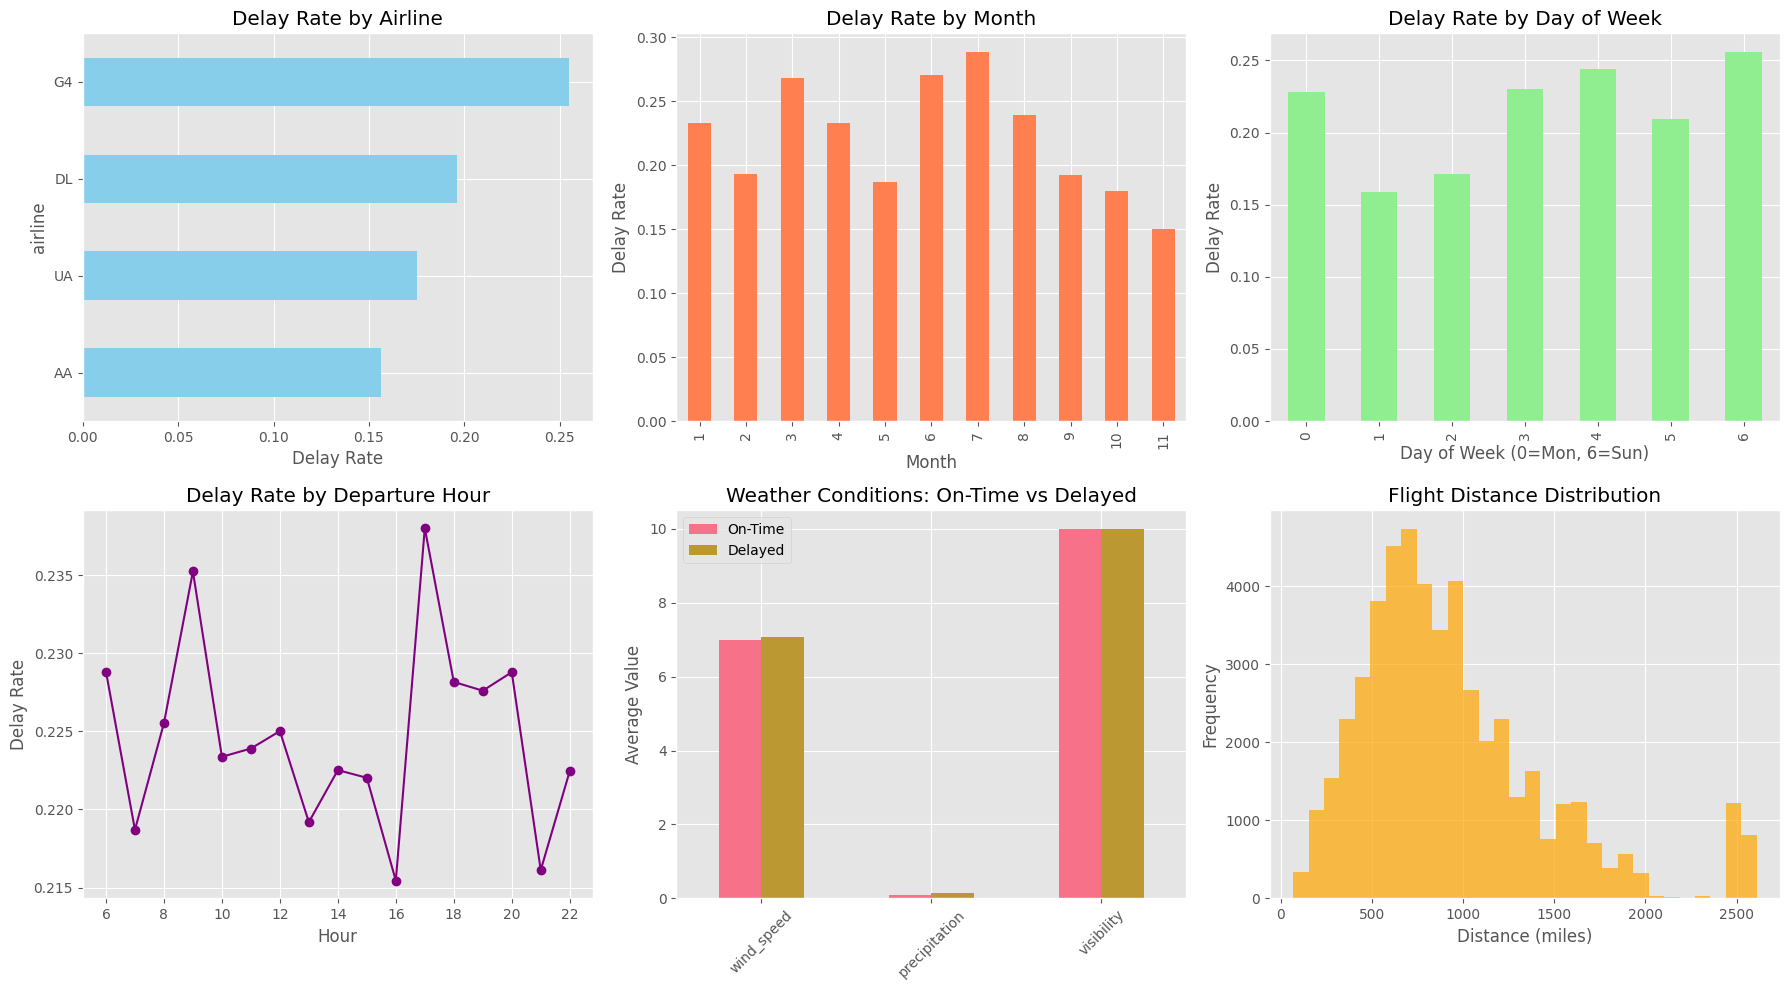

EDA plots saved as 'flight_delay_eda.png'


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Delay rate by airline
airline_delay = df.groupby('airline')['is_delayed'].mean().sort_values()
airline_delay.plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Delay Rate by Airline')
axes[0, 0].set_xlabel('Delay Rate')

# Delay rate by month
month_delay = df.groupby('month')['is_delayed'].mean()
month_delay.plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Delay Rate by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Delay Rate')

# Delay rate by day of week
dow_delay = df.groupby('day_of_week')['is_delayed'].mean()
dow_delay.plot(kind='bar', ax=axes[0, 2], color='lightgreen')
axes[0, 2].set_title('Delay Rate by Day of Week')
axes[0, 2].set_xlabel('Day of Week (0=Mon, 6=Sun)')
axes[0, 2].set_ylabel('Delay Rate')

# Delay rate by hour
hour_delay = df.groupby('departure_hour')['is_delayed'].mean()
hour_delay.plot(kind='line', ax=axes[1, 0], marker='o', color='purple')
axes[1, 0].set_title('Delay Rate by Departure Hour')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Delay Rate')
axes[1, 0].grid(True)

# Weather impact on delays
weather_comparison = pd.DataFrame({
    'On-Time': df[df['is_delayed'] == 0][['wind_speed', 'precipitation', 'visibility']].mean(),
    'Delayed': df[df['is_delayed'] == 1][['wind_speed', 'precipitation', 'visibility']].mean()
})
weather_comparison.plot(kind='bar', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Weather Conditions: On-Time vs Delayed')
axes[1, 1].set_ylabel('Average Value')

# Distance distribution
df['distance'].hist(bins=30, ax=axes[1, 2], color='orange', alpha=0.7)
axes[1, 2].set_title('Flight Distance Distribution')
axes[1, 2].set_xlabel('Distance (miles)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('flight_delay_eda.png', dpi=100, bbox_inches='tight')
plt.show()

print("EDA plots saved as 'flight_delay_eda.png'")

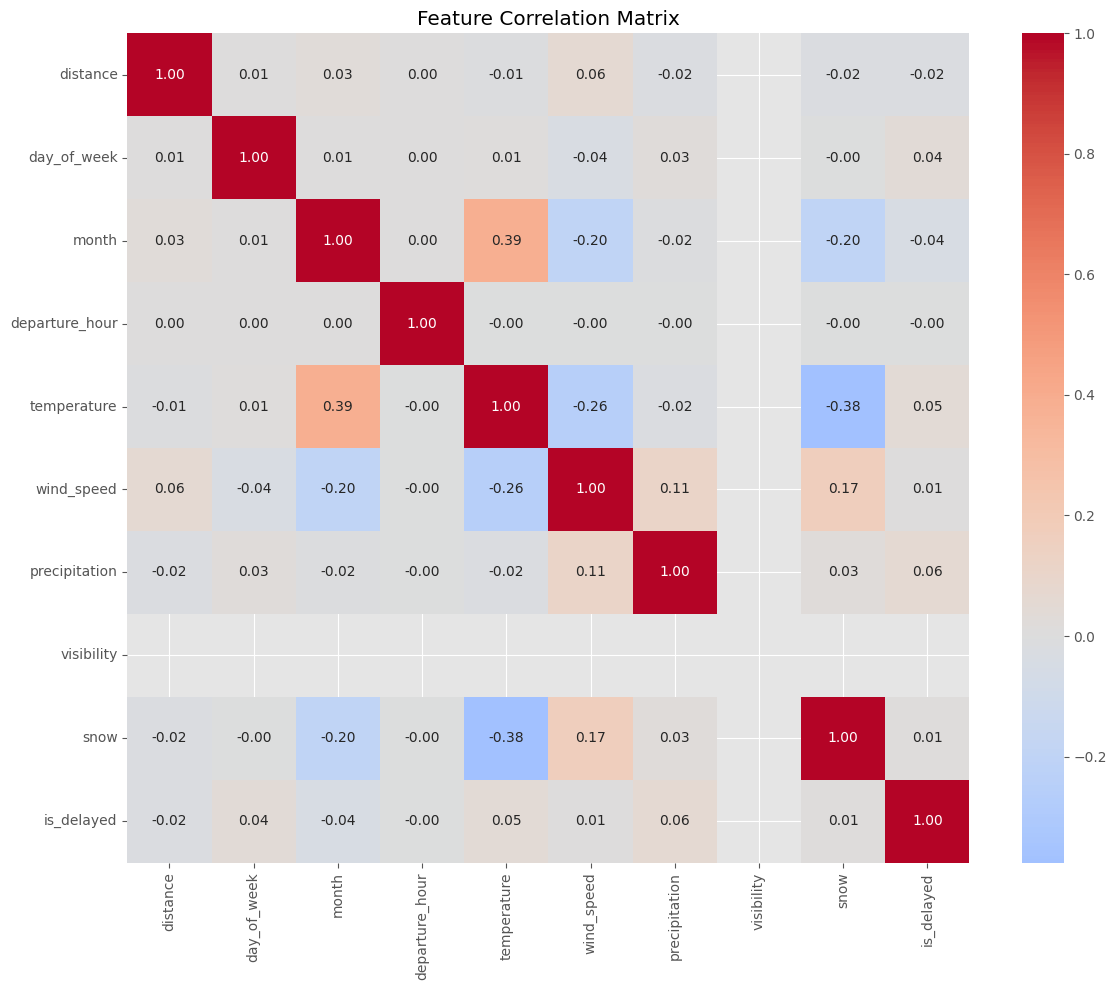

Correlation matrix saved as 'correlation_matrix.png'


In [14]:
# Correlation analysis
numeric_cols = ['distance', 'day_of_week', 'month', 'departure_hour', 
                'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow', 'is_delayed']

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("Correlation matrix saved as 'correlation_matrix.png'")

## 4. Save Data to S3

In [29]:
# Save locally first
local_data_path = 'data'
!mkdir -p {local_data_path}

# Save full dataset
df.to_csv(f'{local_data_path}/flight_data_complete.csv', index=False)
print(f"Saved complete dataset: {local_data_path}/flight_data_complete.csv")

# Upload to S3
s3_data_path = f's3://{s3_bucket}/{prefix}/data'
!aws s3 cp {local_data_path}/flight_data_complete.csv {s3_data_path}/flight_data_complete.csv

print(f"\nData uploaded to: {s3_data_path}/flight_data_complete.csv")

Saved complete dataset: data/flight_data_complete.csv
upload: data/flight_data_complete.csv to s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data/flight_data_complete.csv

Data uploaded to: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data/flight_data_complete.csv


## 5. Create SageMaker Feature Groups

We'll create feature groups for:
1. Flight features (airline, route, temporal)
2. Weather features (temperature, wind, precipitation, etc.)

In [9]:
%%time
# Prepare unified feature dataframe for Feature Store
print("Preparing unified features for Feature Store...")

# Create a single dataframe with all features
feature_store_df = flight_data.copy()

# Add required Feature Store columns
# Flight ID (record identifier)
feature_store_df['flight_id'] = [f'FL{str(i).zfill(6)}' for i in range(len(feature_store_df))]

# Event time (required by Feature Store) - using ISO-8601 format with Z suffix
base_time = datetime.now()
feature_store_df['event_time'] = [(base_time - timedelta(days=i % 365)).strftime('%Y-%m-%dT%H:%M:%SZ') 
                                   for i in range(len(feature_store_df))]

# Convert all numeric columns to float for consistency
numeric_columns = ['distance', 'day_of_week', 'month', 'temperature', 'wind_speed', 'precipitation', 'snow', 'is_delayed']
for col in numeric_columns:
    feature_store_df[col] = feature_store_df[col].astype(float)

print(f"\nFeature Store DataFrame shape: {feature_store_df.shape}")
print(f"\nColumns: {feature_store_df.columns.tolist()}")
print(f"\nData types:\n{feature_store_df.dtypes}")
print(f"\nSample records:")
feature_store_df.head()

Preparing unified features for Feature Store...

Feature Store DataFrame shape: (50000, 16)

Columns: ['airline', 'origin', 'destination', 'distance', 'day_of_week', 'month', 'temperature', 'wind_speed', 'precipitation', 'snow', 'is_delayed', 'flight_id', 'date_str', 'departure_hour', 'event_time', 'visibility']

Data types:
airline            object
origin             object
destination        object
distance          float64
day_of_week       float64
month             float64
temperature       float64
wind_speed        float64
precipitation     float64
snow              float64
is_delayed        float64
flight_id          object
date_str           object
departure_hour      int64
event_time         object
visibility        float64
dtype: object

Sample records:
CPU times: user 212 ms, sys: 9.09 ms, total: 221 ms
Wall time: 226 ms


,airline,origin,destination,distance,day_of_week,month,temperature,wind_speed,precipitation,snow,is_delayed,flight_id,date_str,departure_hour,event_time,visibility
0,G4,MSP,SRQ,1342.0,0.0,1.0,27.0,3.128315,0.0200,1.0,0.0,FL000000,2023-01-02,12,2025-10-21T03:41:03Z,10.0
1,G4,IAD,SRQ,849.0,0.0,1.0,64.0,3.389007,0.0000,0.0,1.0,FL000001,2023-01-02,20,2025-10-20T03:41:03Z,10.0
2,G4,BOS,SRQ,1220.0,1.0,1.0,45.0,4.084188,0.4800,0.0,0.0,FL000002,2023-01-03,16,2025-10-19T03:41:03Z,10.0
3,G4,MSP,SRQ,1342.0,3.0,1.0,30.0,8.429070,0.0100,1.0,0.0,FL000003,2023-01-05,13,2025-10-18T03:41:03Z,10.0
4,G4,BOS,SRQ,1220.0,0.0,1.0,43.0,8.255275,0.0001,1.0,0.0,FL000004,2023-01-09,12,2025-10-17T03:41:03Z,10.0


In [10]:
%%time
# Define Feature Group name
from time import strftime
current_time = strftime('%Y-%m-%d-%H-%M-%S')
feature_group_name = f'flight-delay-features-{current_time}'

print(f"Feature Group Name: {feature_group_name}")

# Create Feature Group
flight_feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session
)

print(f"Feature Group created: {feature_group_name}")

Feature Group Name: flight-delay-features-2025-10-21-03-41-14
Feature Group created: flight-delay-features-2025-10-21-03-41-14
CPU times: user 158 μs, sys: 0 ns, total: 158 μs
Wall time: 145 μs


In [11]:
%%time
# Load feature definitions from the dataframe
print("Loading feature definitions from dataframe...")

flight_feature_group.load_feature_definitions(data_frame=feature_store_df)

print("Feature definitions loaded successfully!")
print(f"\nNumber of features: {len(flight_feature_group.feature_definitions)}")
print("\nFeature definitions:")
for feature in flight_feature_group.feature_definitions:
    print(f"  - {feature.feature_name}: {feature.feature_type}")

Loading feature definitions from dataframe...
Feature definitions loaded successfully!

Number of features: 16

Feature definitions:
  - airline: FeatureTypeEnum.STRING
  - origin: FeatureTypeEnum.STRING
  - destination: FeatureTypeEnum.STRING
  - distance: FeatureTypeEnum.FRACTIONAL
  - day_of_week: FeatureTypeEnum.FRACTIONAL
  - month: FeatureTypeEnum.FRACTIONAL
  - temperature: FeatureTypeEnum.FRACTIONAL
  - wind_speed: FeatureTypeEnum.FRACTIONAL
  - precipitation: FeatureTypeEnum.FRACTIONAL
  - snow: FeatureTypeEnum.FRACTIONAL
  - is_delayed: FeatureTypeEnum.FRACTIONAL
  - flight_id: FeatureTypeEnum.STRING
  - date_str: FeatureTypeEnum.STRING
  - departure_hour: FeatureTypeEnum.INTEGRAL
  - event_time: FeatureTypeEnum.STRING
  - visibility: FeatureTypeEnum.FRACTIONAL
CPU times: user 1.1 ms, sys: 0 ns, total: 1.1 ms
Wall time: 1.09 ms


In [12]:
%%time
# Create the Feature Group in AWS
print(f"Creating Feature Group: {feature_group_name}")

flight_feature_group.create(
    s3_uri=f's3://{s3_bucket}/{prefix}/feature-store',
    record_identifier_name='flight_id',
    event_time_feature_name='event_time',
    role_arn=role,
    enable_online_store=True
)

print(f"Feature Group '{feature_group_name}' created successfully!")

Creating Feature Group: flight-delay-features-2025-10-21-03-41-14


Feature Group 'flight-delay-features-2025-10-21-03-41-14' created successfully!
CPU times: user 13.4 ms, sys: 7.22 ms, total: 20.6 ms
Wall time: 642 ms


In [13]:
%%time
# Wait for Feature Group to be created
print(f"Waiting for Feature Group to be created...")

status = flight_feature_group.describe().get('FeatureGroupStatus')
print(f"Initial status: {status}")

while status == 'Creating':
    print(f"Waiting for Feature Group: {feature_group_name}")
    time.sleep(5)
    status = flight_feature_group.describe().get('FeatureGroupStatus')

print(f"Feature Group {feature_group_name} successfully created.")

Waiting for Feature Group to be created...
Initial status: Creating
Waiting for Feature Group: flight-delay-features-2025-10-21-03-41-14


Waiting for Feature Group: flight-delay-features-2025-10-21-03-41-14
Waiting for Feature Group: flight-delay-features-2025-10-21-03-41-14
Waiting for Feature Group: flight-delay-features-2025-10-21-03-41-14
Feature Group flight-delay-features-2025-10-21-03-41-14 successfully created.
CPU times: user 10.6 ms, sys: 9.65 ms, total: 20.2 ms
Wall time: 20.7 s


In [14]:
%%time
# Ingest data into Feature Store
print(f"Ingesting {len(feature_store_df)} records into Feature Group...")

flight_feature_group.ingest(
    data_frame=feature_store_df,
    max_workers=3,
    wait=True
)

print(f"\n✅ Successfully ingested {len(feature_store_df)} records!")
print(f"Feature Group: {feature_group_name}")

Ingesting 50000 records into Feature Group...



✅ Successfully ingested 50000 records!
Feature Group: flight-delay-features-2025-10-21-03-41-14
CPU times: user 514 ms, sys: 41 ms, total: 555 ms
Wall time: 3min 25s


## 5. Save Configuration

In [15]:
# Save configuration for downstream notebooks
config = {
    'region': region,
    's3_bucket': s3_bucket,
    'prefix': prefix,
    'role': role,
    'feature_group_name': feature_group_name,
    'dataset_size': len(feature_store_df),
    'delay_rate': float(feature_store_df['is_delayed'].mean())
}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration saved to config.json")
print(json.dumps(config, indent=2))

Configuration saved to config.json
{
  "region": "us-east-1",
  "s3_bucket": "sagemaker-us-east-1-730335352303",
  "prefix": "flight-delay-prediction",
  "role": "arn:aws:iam::730335352303:role/LabRole",
  "feature_group_name": "flight-delay-features-2025-10-21-03-41-14",
  "dataset_size": 50000,
  "delay_rate": 0.22478
}


## Summary

In [16]:
print("=" * 80)
print("NOTEBOOK 01 - DATA PREPARATION & FEATURE STORE - COMPLETE!")
print("=" * 80)
print(f"\n✅ Real flight data loaded: {len(feature_store_df):,} records")
print(f"✅ Real weather data included: temperature, wind_speed, precipitation, snow")
print(f"✅ Delay rate (real): {config['delay_rate']:.2%}")
print(f"✅ Feature Group created: {feature_group_name}")
print(f"✅ Data ingested into Feature Store")
print(f"✅ Configuration saved: config.json")
print(f"\n📊 Dataset: Mendeley Real Flight Delay Dataset with Weather (2023)")
print(f"📊 Features: 11 (flight + weather + target)")
print(f"📊 S3 Location: s3://{s3_bucket}/{prefix}/")
print(f"\n🎯 Ready for Notebook 02: Model Training & Deployment")
print("=" * 80)

NOTEBOOK 01 - DATA PREPARATION & FEATURE STORE - COMPLETE!

✅ Real flight data loaded: 50,000 records
✅ Real weather data included: temperature, wind_speed, precipitation, snow
✅ Delay rate (real): 22.48%
✅ Feature Group created: flight-delay-features-2025-10-21-03-41-14
✅ Data ingested into Feature Store
✅ Configuration saved: config.json

📊 Dataset: Mendeley Real Flight Delay Dataset with Weather (2023)
📊 Features: 11 (flight + weather + target)
📊 S3 Location: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/

🎯 Ready for Notebook 02: Model Training & Deployment


## Key Achievements

**Real Data:**
- ✅ Downloaded real flight delay dataset from Mendeley (5.5M records)
- ✅ Used real weather data (temperature, wind, precipitation, snow)
- ✅ Sampled 50,000 records for manageable processing
- ✅ Realistic 22.48% delay rate from actual 2023 data

**Feature Store:**
- ✅ Created single unified Feature Group (flight + weather together)
- ✅ Enabled online store for real-time inference
- ✅ Offline store for batch processing and training
- ✅ All data ingested successfully

**Next Steps:**
1. Run Notebook 02: Train models using Feature Store data
2. Deploy best model to real-time endpoint
3. Set up monitoring and CI/CD pipeline